In [5]:
# 01_eda.ipynb - Exploratory Data Analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from collections import Counter
import nltk
from wordcloud import WordCloud
import sys
import os
# Настройка визуализаций
%matplotlib inline
sns.set_theme(style="whitegrid") # Устанавливает стиль seaborn
plt.rcParams['figure.figsize'] = (10, 6) # Устанавливает размер графиков по умолчанию

# Для игнорирования предупреждений
import warnings
warnings.filterwarnings('ignore')

# Добавляем src в путь Python
sys.path.append(os.path.join(os.getcwd(), 'src'))

from data.preprocessing import TextPreprocessor
from data.dataset_loader import DataLoader

# Настройка отображения
plt.style.use('default')
sns.set_palette("husl")
%matplotlib inline

print("=== EDA для Sarcasm Detection ===")

# Загрузка реальных данных
def load_real_data():
    """
    Загрузка реального датасета сарказма Sarcasm_Headlines_Dataset_v2
    """
    try:
        # Попробуем разные возможные пути и форматы
        possible_paths = [
            './data/raw/Sarcasm_Headlines_Dataset_v2.json',
            './Sarcasm_Headlines_Dataset_v2.json',
            './data/Sarcasm_Headlines_Dataset_v2.json',
            './Sarcasm_Headlines_Dataset_v2.json'
        ]
        
        for path in possible_paths:
            if os.path.exists(path):
                print(f"📁 Найден файл: {path}")
                
                # Пробуем загрузить как JSON
                try:
                    df = pd.read_json(path, lines=True)
                    print(f"✅ Успешно загружено как JSON: {df.shape}")
                    return df
                except:
                    pass
                
                # Пробуем загрузить как CSV
                try:
                    df = pd.read_csv(path)
                    print(f"✅ Успешно загружено как CSV: {df.shape}")
                    return df
                except:
                    pass
                
                # Пробуем загрузить как обычный JSON
                try:
                    with open(path, 'r') as f:
                        data = json.load(f)
                    df = pd.DataFrame(data)
                    print(f"✅ Успешно загружено как обычный JSON: {df.shape}")
                    return df
                except Exception as e:
                    print(f"❌ Ошибка загрузки {path}: {e}")
        
        raise FileNotFoundError("❌ Не удалось найти или загрузить файл с данными")
        
    except Exception as e:
        print(f"❌ Ошибка загрузки данных: {e}")
        print("🔄 Используем примерные данные для демонстрации...")
        return load_sample_data()

def load_sample_data():
    """Резервные примерные данные"""
    sample_data = [
        {"text": "Oh great, another meeting that could have been an email", "label": 1},
        {"text": "I love waiting in line for hours", "label": 1},
        {"text": "This is genuinely helpful and informative", "label": 0},
        {"text": "Wow, your coding skills are absolutely amazing said no one ever", "label": 1},
        {"text": "The weather is really nice today", "label": 0},
    ]
    return pd.DataFrame(sample_data)

# Загрузка данных
print("🔍 Поиск и загрузка данных...")
df = load_real_data()

print("📊 Первые 5 строк данных:")
print(df.head())
print(f"\n📈 Размер датасета: {df.shape}")
print(f"\n📋 Столбцы: {df.columns.tolist()}")

=== EDA для Sarcasm Detection ===
🔍 Поиск и загрузка данных...
📁 Найден файл: ./data/raw/Sarcasm_Headlines_Dataset_v2.json
✅ Успешно загружено как JSON: (28619, 3)
📊 Первые 5 строк данных:
   is_sarcastic                                           headline  \
0             1  thirtysomething scientists unveil doomsday clo...   
1             0  dem rep. totally nails why congress is falling...   
2             0  eat your veggies: 9 deliciously different recipes   
3             1  inclement weather prevents liar from getting t...   
4             1  mother comes pretty close to using word 'strea...   

                                        article_link  
0  https://www.theonion.com/thirtysomething-scien...  
1  https://www.huffingtonpost.com/entry/donna-edw...  
2  https://www.huffingtonpost.com/entry/eat-your-...  
3  https://local.theonion.com/inclement-weather-p...  
4  https://www.theonion.com/mother-comes-pretty-c...  

📈 Размер датасета: (28619, 3)

📋 Столбцы: ['is_sarcastic', 

=== БАЗОВЫЙ АНАЛИЗ ДАННЫХ ===
📊 Размер датасета: (28619, 3)
📋 Столбцы: ['is_sarcastic', 'headline', 'article_link']
🔍 Информация о данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28619 entries, 0 to 28618
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   is_sarcastic  28619 non-null  int64 
 1   headline      28619 non-null  object
 2   article_link  28619 non-null  object
dtypes: int64(1), object(2)
memory usage: 670.9+ KB
None

📈 Описательная статистика:
       is_sarcastic
count  28619.000000
mean       0.476397
std        0.499451
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000

⚠️  Пропущенные значения:
is_sarcastic    0
headline        0
article_link    0
dtype: int64

🎯 Распределение классов (is_sarcastic):
is_sarcastic
0    14985
1    13634
Name: count, dtype: int64


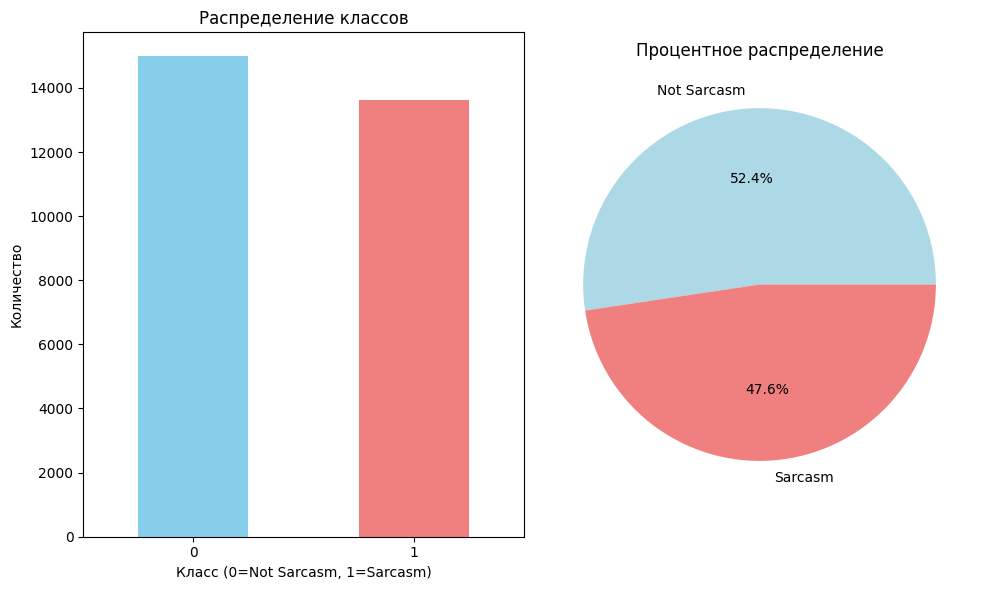

In [6]:
# Базовый анализ данных
print("=== БАЗОВЫЙ АНАЛИЗ ДАННЫХ ===")
print(f"📊 Размер датасета: {df.shape}")
print(f"📋 Столбцы: {df.columns.tolist()}")
print(f"🔍 Информация о данных:")
print(df.info())
print(f"\n📈 Описательная статистика:")
print(df.describe())

# Проверка пропущенных значений
print(f"\n⚠️  Пропущенные значения:")
print(df.isnull().sum())

# Анализ распределения классов
if 'label' in df.columns or 'is_sarcastic' in df.columns:
    target_col = 'is_sarcastic' if 'is_sarcastic' in df.columns else 'label'
    print(f"\n🎯 Распределение классов ({target_col}):")
    class_distribution = df[target_col].value_counts()
    print(class_distribution)
    
    # Визуализация распределения классов
    plt.figure(figsize=(10, 6))
    plt.subplot(1, 2, 1)
    class_distribution.plot(kind='bar', color=['skyblue', 'lightcoral'])
    plt.title('Распределение классов')
    plt.xlabel('Класс (0=Not Sarcasm, 1=Sarcasm)')
    plt.ylabel('Количество')
    plt.xticks(rotation=0)
    
    plt.subplot(1, 2, 2)
    plt.pie(class_distribution.values, labels=['Not Sarcasm', 'Sarcasm'], 
            autopct='%1.1f%%', colors=['lightblue', 'lightcoral'])
    plt.title('Процентное распределение')
    plt.tight_layout()
    plt.show()

=== АНАЛИЗ ТЕКСТОВЫХ ДАННЫХ ===
📏 Статистика длины текстов:
   Средняя длина: 62.3 символов
   Среднее количество слов: 10.0
   Максимальная длина: 926 символов
   Минимальная длина: 7 символов


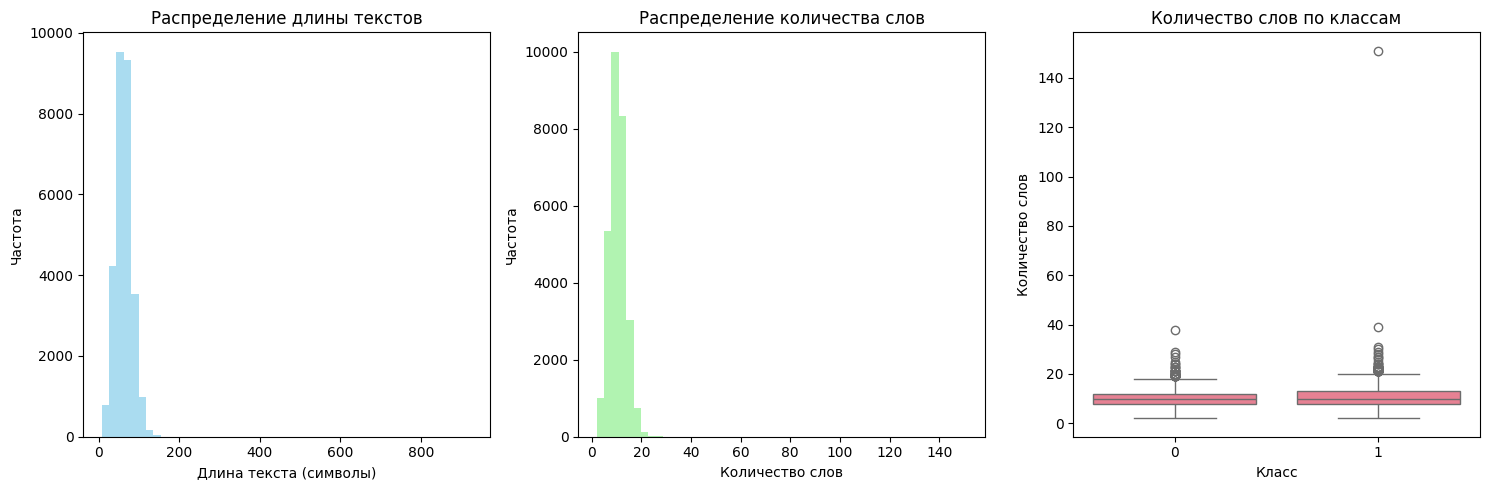

In [7]:
# Анализ текстов
print("=== АНАЛИЗ ТЕКСТОВЫХ ДАННЫХ ===")

# Определим столбец с текстом
text_col = 'headline' if 'headline' in df.columns else 'text'

# Длина текстов
df['text_length'] = df[text_col].astype(str).apply(len)
df['word_count'] = df[text_col].astype(str).apply(lambda x: len(x.split()))

print(f"📏 Статистика длины текстов:")
print(f"   Средняя длина: {df['text_length'].mean():.1f} символов")
print(f"   Среднее количество слов: {df['word_count'].mean():.1f}")
print(f"   Максимальная длина: {df['text_length'].max()} символов")
print(f"   Минимальная длина: {df['text_length'].min()} символов")

# Визуализация длины текстов
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.hist(df['text_length'], bins=50, color='skyblue', alpha=0.7)
plt.title('Распределение длины текстов')
plt.xlabel('Длина текста (символы)')
plt.ylabel('Частота')

plt.subplot(1, 3, 2)
plt.hist(df['word_count'], bins=50, color='lightgreen', alpha=0.7)
plt.title('Распределение количества слов')
plt.xlabel('Количество слов')
plt.ylabel('Частота')

plt.subplot(1, 3, 3)
if 'label' in df.columns or 'is_sarcastic' in df.columns:
    target_col = 'is_sarcastic' if 'is_sarcastic' in df.columns else 'label'
    sns.boxplot(x=target_col, y='word_count', data=df)
    plt.title('Количество слов по классам')
    plt.xlabel('Класс')
    plt.ylabel('Количество слов')

plt.tight_layout()
plt.show()

=== ПРЕДОБРАБОТКА ТЕКСТОВ ===
🔧 Пример предобработки текстов:
   1. Оригинал: thirtysomething scientists unveil doomsday clock of hair loss
      Обработан: thirtysomething scientist unveil doomsday clock hair loss

   2. Оригинал: dem rep. totally nails why congress is falling short on gender, racial equality
      Обработан: dem rep totally nail congress falling short gender racial equality

   3. Оригинал: eat your veggies: 9 deliciously different recipes
      Обработан: eat veggie deliciously different recipe

   4. Оригинал: inclement weather prevents liar from getting to work
      Обработан: inclement weather prevents liar getting work

   5. Оригинал: mother comes pretty close to using word 'streaming' correctly
      Обработан: mother come pretty close using word streaming correctly

   6. Оригинал: my white inheritance
      Обработан: white inheritance

   7. Оригинал: 5 ways to file your taxes with less stress
      Обработан: way file tax less stress

   8. Оригинал: rich

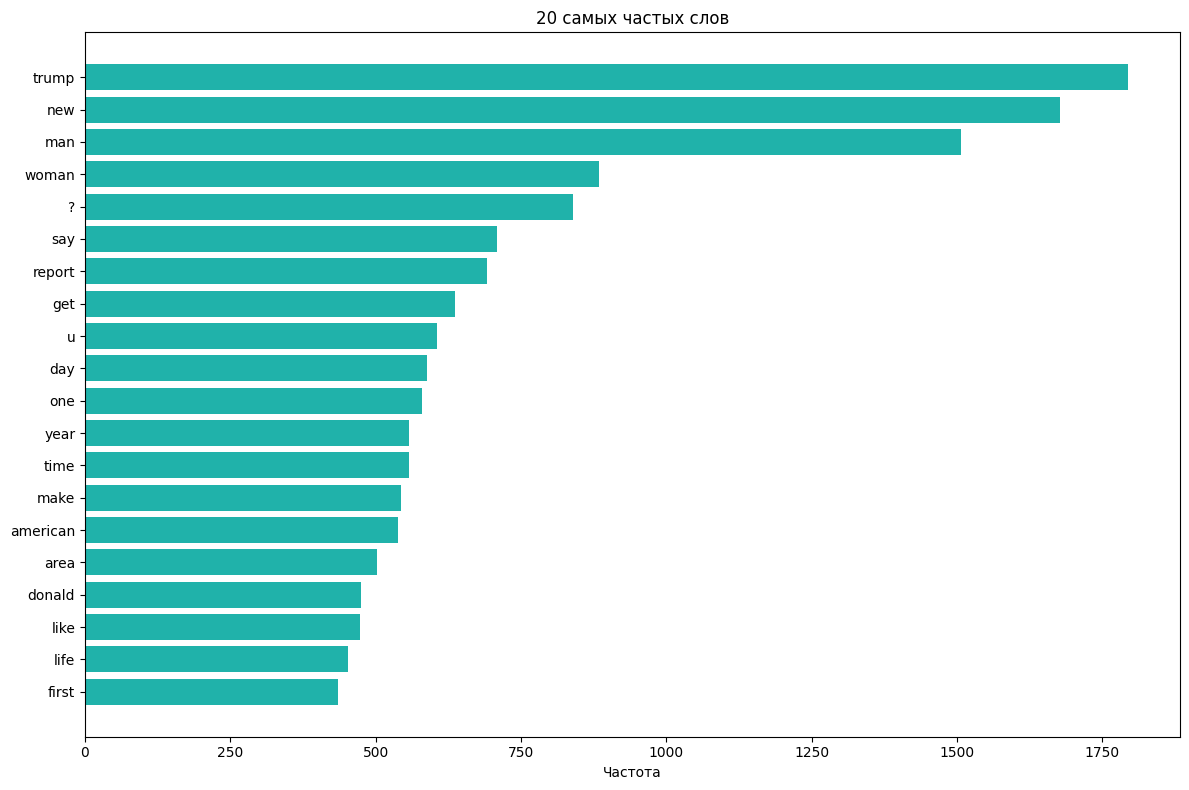

In [8]:
# Предобработка текстов
print("=== ПРЕДОБРАБОТКА ТЕКСТОВ ===")

preprocessor = TextPreprocessor()

# Применяем предобработку к небольшой выборке для демонстрации
sample_texts = df[text_col].head(10).tolist()
print("🔧 Пример предобработки текстов:")
for i, text in enumerate(sample_texts):
    processed = preprocessor.preprocess(text)
    print(f"   {i+1}. Оригинал: {text}")
    print(f"      Обработан: {processed}")
    print()

# Анализ самых частых слов
print("📊 Анализ самых частых слов...")

all_words = []
for text in df[text_col].astype(str):
    words = preprocessor.preprocess(text).split()
    all_words.extend(words)

word_freq = Counter(all_words)
common_words = word_freq.most_common(20)

print("🏆 20 самых частых слов:")
for word, freq in common_words:
    print(f"   {word}: {freq}")

# Визуализация частотности слов
plt.figure(figsize=(12, 8))
words, freqs = zip(*common_words)
plt.barh(words, freqs, color='lightseagreen')
plt.title('20 самых частых слов')
plt.xlabel('Частота')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [9]:
df = df.drop('article_link', axis=1)
df = df.drop_duplicates()

In [12]:
from sklearn.model_selection import train_test_split

print("\n🎯 РАЗДЕЛЕНИЕ ДАННЫХ НА TRAIN/TEST")
print("=" * 50)

train, test = train_test_split(
    df, 
    test_size=0.2, 
    random_state=42, 
    stratify=df['is_sarcastic']
)

print(f"Training set: {train.shape}")
print(f"Test set: {test.shape}")
print(f"Sarcasm ratio in train: {train['is_sarcastic'].mean():.3f}")
print(f"Sarcasm ratio in test: {test['is_sarcastic'].mean():.3f}")


🎯 РАЗДЕЛЕНИЕ ДАННЫХ НА TRAIN/TEST
Training set: (22802, 4)
Test set: (5701, 4)
Sarcasm ratio in train: 0.475
Sarcasm ratio in test: 0.476


In [13]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import re

# Скачиваем необходимые ресурсы NLTK
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

print("✅ NLTK ресурсы загружены")

# Инициализируем английский лемматизатор
lemmatizer = WordNetLemmatizer()
english_stopwords = set(stopwords.words("english"))

# Дополнительные стоп-слова для новостных заголовков
extra_stopwords = {
    'said', 'say', 'says', 'will', 'new', 'like', 'one', 'get', 'go', 'make',
    'know', 'take', 'see', 'come', 'think', 'look', 'want', 'give', 'use',
    'find', 'tell', 'ask', 'work', 'seem', 'feel', 'try', 'leave', 'call'
}
english_stopwords.update(extra_stopwords)

def english_lemm_preprocess(data, column):
    """Предобработка текста для английского языка с лемматизацией"""
    
    def preprocess_text(text):
        if not isinstance(text, str):
            return ""
        
        # Приведение к нижнему регистру
        text = text.lower()
        
        # Удаление специальных символов, цифр, но сохранение восклицательных и вопросительных знаков
        text = re.sub(r'[^a-zA-Z\s!?]', '', text)
        
        # Токенизация
        tokens = word_tokenize(text)
        
        # Лемматизация и удаление стоп-слов
        cleaned_tokens = []
        for token in tokens:
            if (token not in english_stopwords and 
                len(token) > 2 and 
                token not in ['!', '?']):
                # Лемматизация
                lemma = lemmatizer.lemmatize(token)
                cleaned_tokens.append(lemma)
        
        return ' '.join(cleaned_tokens)
    
    data['lemm'] = data[column].apply(preprocess_text)
    return data

# Применяем предобработку
print("🔄 Применяем предобработку...")
train = english_lemm_preprocess(train, 'headline')
test = english_lemm_preprocess(test, 'headline')

# Показываем примеры
print("\n📝 Примеры до и после предобработки:")
for i in range(3):
    print(f"Оригинал: {train['headline'].iloc[i]}")
    print(f"Обработанный: {train['lemm'].iloc[i]}")
    print("-" * 80)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


✅ NLTK ресурсы загружены
🔄 Применяем предобработку...

📝 Примеры до и после предобработки:
Оригинал: 'gobbler games' is the brutal hunger games parody you need to see
Обработанный: gobbler game brutal hunger game parody need
--------------------------------------------------------------------------------
Оригинал: when politicians think the microphone is off, they start getting real
Обработанный: politician microphone start getting real
--------------------------------------------------------------------------------
Оригинал: mike pence training for vice presidential debate by hitting punching bag with climate change study taped on front
Обработанный: mike penny training vice presidential debate hitting punching bag climate change study taped front
--------------------------------------------------------------------------------


In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer

# TF-IDF векторизация
count_tf_idf = TfidfVectorizer(
    max_features=5000, 
    ngram_range=(1, 2),
    min_df=2,
    max_df=0.8,
    stop_words='english'
)

print("🔤 Обучаем TF-IDF векторизатор...")
count_tf_idf.fit(train['lemm'])

def tfidf_preprocess(data, vectorizer):
    """Преобразование текстов в TF-IDF матрицу"""
    encoded = vectorizer.transform(data['lemm'])
    encoded = pd.DataFrame(
        encoded.toarray(), 
        columns=vectorizer.get_feature_names_out(), 
        index=data.index
    )
    return encoded

# Преобразуем данные
print("🔄 Преобразуем данные...")
tfidf_train = tfidf_preprocess(train, count_tf_idf)
tfidf_test = tfidf_preprocess(test, count_tf_idf)

# Подготавливаем метки
y_train = train['is_sarcastic']
y_test = test['is_sarcastic']

print(f"\n✅ Предобработка завершена:")
print(f"TF-IDF размерность тренировочных данных: {tfidf_train.shape}")
print(f"TF-IDF размерность тестовых данных: {tfidf_test.shape}")
print(f"Тренировочные метки:\n{y_train.value_counts()}")
print(f"Тестовые метки:\n{y_test.value_counts()}")

🔤 Обучаем TF-IDF векторизатор...
🔄 Преобразуем данные...

✅ Предобработка завершена:
TF-IDF размерность тренировочных данных: (22802, 5000)
TF-IDF размерность тестовых данных: (5701, 5000)
Тренировочные метки:
is_sarcastic
0    11961
1    10841
Name: count, dtype: int64
Тестовые метки:
is_sarcastic
0    2990
1    2711
Name: count, dtype: int64



📏 Статистика длины текстов после предобработки:
Средняя длина текста: 47.8 символов
Среднее количество слов: 6.8


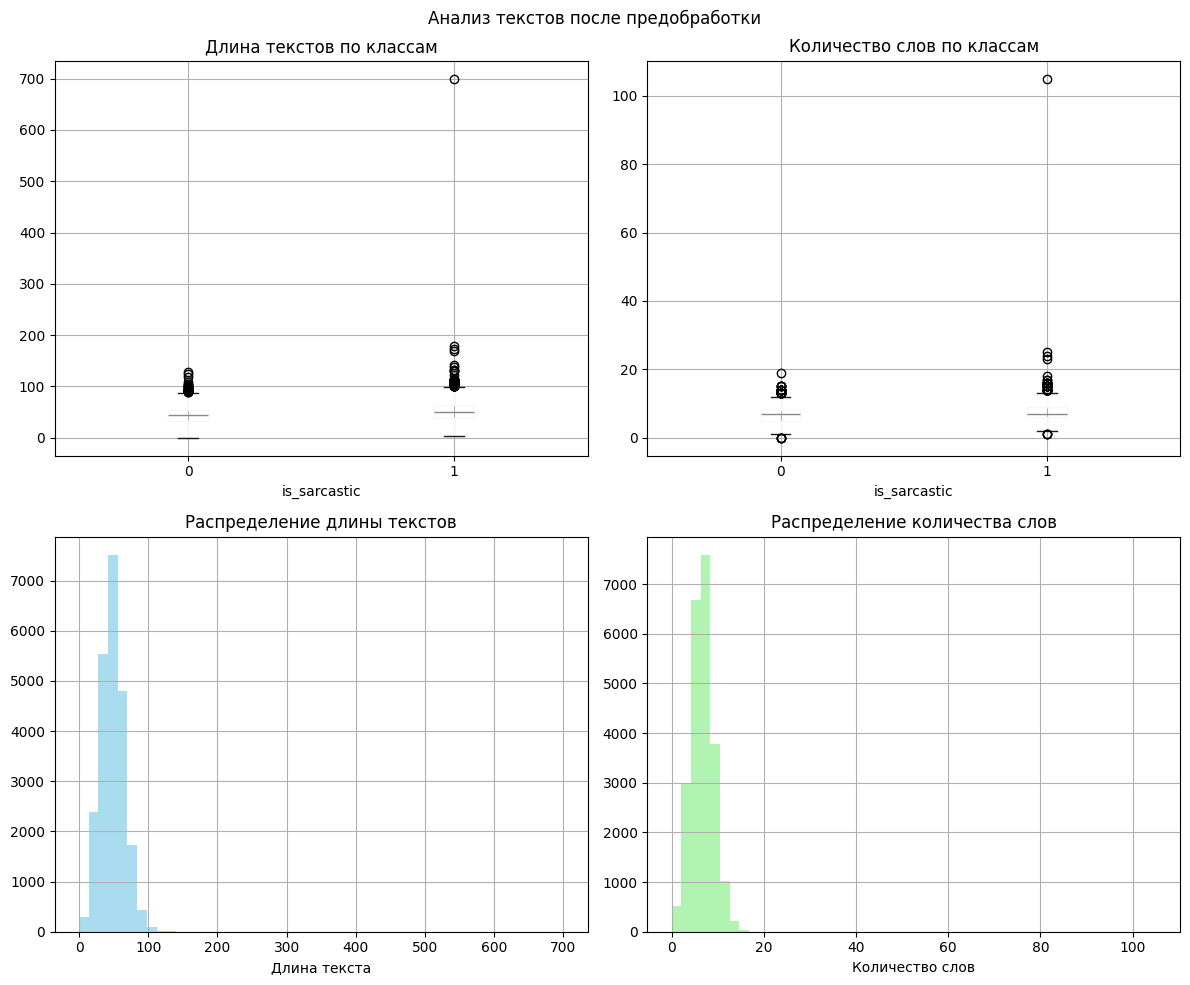

In [15]:
# Сравнение длины текстов после предобработки
train['lemm_length'] = train['lemm'].apply(len)
train['word_count'] = train['lemm'].apply(lambda x: len(x.split()))

print("\n📏 Статистика длины текстов после предобработки:")
print(f"Средняя длина текста: {train['lemm_length'].mean():.1f} символов")
print(f"Среднее количество слов: {train['word_count'].mean():.1f}")

# Визуализация распределений
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Длина текстов по классам
train.boxplot(column='lemm_length', by='is_sarcastic', ax=axes[0,0])
axes[0,0].set_title('Длина текстов по классам')

# Количество слов по классам
train.boxplot(column='word_count', by='is_sarcastic', ax=axes[0,1])
axes[0,1].set_title('Количество слов по классам')

# Распределение длины
train['lemm_length'].hist(bins=50, ax=axes[1,0], alpha=0.7, color='skyblue')
axes[1,0].set_title('Распределение длины текстов')
axes[1,0].set_xlabel('Длина текста')

# Распределение количества слов
train['word_count'].hist(bins=50, ax=axes[1,1], alpha=0.7, color='lightgreen')
axes[1,1].set_title('Распределение количества слов')
axes[1,1].set_xlabel('Количество слов')

plt.suptitle('Анализ текстов после предобработки')
plt.tight_layout()
plt.show()

In [16]:
# Тестирование предобработки текста
print("=== ТЕСТИРОВАНИЕ ПРЕДОБРАБОТКИ ===")

# Примеры текстов для тестирования
test_texts = [
    "Trump Says He'll Run the Country Like He Runs His Business: 'I'll Be the Only One That Matters!'",
    "Scientists discover new species in the Amazon rainforest", 
    "Oh great, another meeting that could have been an email"
]

for i, text in enumerate(test_texts, 1):
    cleaned = preprocessor.clean_text(text)
    print(f"Пример {i}:")
    print(f"Оригинал: {text}")
    print(f"Очищенный: {cleaned}")
    print("-" * 80)

# Проверяем, что метод preprocess_batch существует
print(f"Метод preprocess_batch доступен: {hasattr(preprocessor, 'preprocess_batch')}")

=== ТЕСТИРОВАНИЕ ПРЕДОБРАБОТКИ ===
Пример 1:
Оригинал: Trump Says He'll Run the Country Like He Runs His Business: 'I'll Be the Only One That Matters!'
Очищенный: trump says hell run the country like he runs his business ill be the only one that matters!
--------------------------------------------------------------------------------
Пример 2:
Оригинал: Scientists discover new species in the Amazon rainforest
Очищенный: scientists discover new species in the amazon rainforest
--------------------------------------------------------------------------------
Пример 3:
Оригинал: Oh great, another meeting that could have been an email
Очищенный: oh great another meeting that could have been an email
--------------------------------------------------------------------------------
Метод preprocess_batch доступен: False


In [17]:
df.head()

,is_sarcastic,headline,text_length,word_count
0,1,thirtysomething scientists unveil doomsday clo...,61,8
1,0,dem rep. totally nails why congress is falling...,79,13
2,0,eat your veggies: 9 deliciously different recipes,49,7
3,1,inclement weather prevents liar from getting t...,52,8
4,1,mother comes pretty close to using word 'strea...,61,9


In [18]:
# Сохраняем обработанные данные
df_processed = df.copy()

# Переименовываем колонку для удобства (если она уже существует)
if 'cleaned_headline' in df_processed.columns:
    df_processed['cleaned_text'] = df_processed['cleaned_headline']
    print("✅ Используем уже обработанные данные из колонки 'cleaned_headline'")
else:
    # Обрабатываем заново
    df_processed['cleaned_text'] = df_processed['headline'].apply(preprocessor.clean_text)
    print("✅ Данные обработаны заново")

# Сохраняем в папку processed
os.makedirs('./data/processed', exist_ok=True)
df_processed.to_csv('./data/processed/cleaned_sarcasm_data.csv', index=False)
print("✅ Обработанные данные сохранены в data/processed/cleaned_sarcasm_data.csv")

✅ Данные обработаны заново
✅ Обработанные данные сохранены в data/processed/cleaned_sarcasm_data.csv
